In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import time
import wandb

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [6]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [7]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [113]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)

    return Xb, Yb

#todo: mettre les shapes a cote

In [114]:
lr = 0.03
batch_size = 1024
embed_dim = 16
hidden_dim = 100
context_len = 3
data = "new"

eval_interval = 500
eval_iter = 50

In [129]:
class BengioLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(3 * embed_dim, hidden_dim)

        self.lm_head = nn.Linear(hidden_dim, len(vocabulaire))

    """
    def forward(self, x):
        x = self.embed(x).view(-1, context_len*embed_dim)

        z1 = self.fc1(x)
        a1 = F.tanh(z1)

        logits = self.lm_head(a1)

        return z1, a1, logits
    """
    
    def forward(self, x, y=None):
        # x : (B, T)
        
        embeddings = [] #liste de tensors (B, T, embed_dim)
          
        embed_char_1 = self.embed(x) #matrice qui stocke les embeddings du premire char du contexte (B, T, embed_dim)
        #embed_char_1 = x.view(64, -1, 1)

        embeddings.append(embed_char_1)

        embed_char_2 = torch.roll(embed_char_1, shifts=1, dims=1) #shift le time de 1 pour obtenir la matrice qui stocke les embeddings du second char du contexte (B, T, embed_dim)
        embed_char_2[:, 0] = self.embed(torch.tensor(1, device=device)) #on met l'embedding de <SOS>

        #embed_char_2[:, 0] = self.embed(torch.zeros(embed_char_2.size(0), dtype=torch.long, device=device))

        embeddings.append(embed_char_2)

        embed_char_3 = torch.roll(embed_char_2, shifts=1, dims=1) # (B, T, embed_dim)
        embed_char_3[:, 0] = self.embed(torch.tensor(1, device=device)) #on met l'embedding de <SOS>
        #embed_char_3[:, 0] = self.embed(torch.zeros(embed_char_2.size(0), dtype=torch.long, device=device))

        embeddings.append(embed_char_3)

        embeddings.reverse()

        x = torch.cat(embeddings, dim=2) # (B, T, 3*embed_dim)
        x = x.view(-1, 3*embed_dim) # (B*T, 3*embed_dim), l'input du MLP

        x = self.fc1(x)
        x = F.tanh(x)

        logits = self.lm_head(x) # (B, T, voc_size)

        loss = None
        if y is not None:
            y = y.view(-1) # (B, T)

            loss = F.cross_entropy(logits, y, ignore_index=0)

        return logits, loss
    
    def sample(self, prompt="", max_new_tokens=None):
        return
    
#todo : remplacer les 0 et -1 par les char_to_int[...]
#todo : voc_size - 1 ou pas pour la lm head ?

In [130]:
#writer = SummaryWriter(log_dir="runs/mlp/batch_size=" + str(batch_size) + "_lr=" + str(lr))
"""
wandb.init(project="bengio_lm",
           config={
               "learning_rate": lr,
               "batch_size": batch_size,
               "embed_dim": embed_dim,
               "hidden_dim": hidden_dim,
               "context_len": context_len,
               "data_loading": data
           })
"""

model = BengioLM()
model.to(device)

BengioLM(
  (embed): Embedding(46, 16, padding_idx=0)
  (fc1): Linear(in_features=48, out_features=100, bias=True)
  (lm_head): Linear(in_features=100, out_features=46, bias=True)
)

In [131]:
losses = []

In [132]:
N = 10000
start_time = time.time()

#wandb.watch(model, log="all")

for update_num in range(N):
    Xb, Yb = get_batch('train', batch_size)

    logits, loss = model(Xb, Yb)

    losses.append(loss.item())

    for p in model.parameters():
        p.grad = None

    loss.backward()

    for p in model.parameters():
        p.data += -lr * p.grad

    """
    # eval : track loss (train & val), update_to_data
    if update_num % eval_interval == 0:
        to_log = {}

        with torch.no_grad():
            model.eval()
            for split in ['train', 'val']:
                loss_mean = 0
                for i in range(eval_iter):
                    Xb, Yb = get_batch(split, batch_size)
                    logits, loss = model(Xb, Yb)

                    loss_mean += loss.item()
                loss_mean /= eval_iter
                to_log["loss_" + split] = loss_mean
            model.train()

            scalars_dict = {}

            for name, p in model.named_parameters():
                scalars_dict[name] = (lr*p.grad.std() / p.data.std()).log10().item()
        
        wandb.log(to_log | {"update_to_data": scalars_dict}, step=update_num)
    """

end_time = time.time()
num_examples_processed = N * batch_size

print("training throughput = {} examples/s".format(str(num_examples_processed/(end_time-start_time))))
"""
wandb.log({"training_throughput": num_examples_processed/(end_time-start_time)})
wandb.log({"params_num": sum([p.numel() for p in model.parameters()])})
"""

training throughput = 325718.1811448856 examples/s


'\nwandb.log({"training_throughput": num_examples_processed/(end_time-start_time)})\nwandb.log({"params_num": sum([p.numel() for p in model.parameters()])})\n'

In [16]:
#wandb.finish()

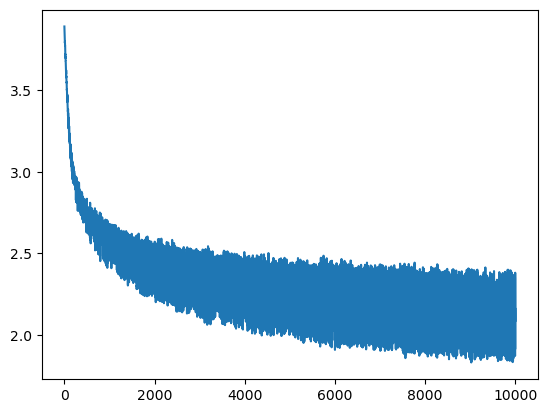

In [133]:
plt.plot(losses)

In [28]:
# sample

g = torch.Generator().manual_seed(40 + 7)

for _ in range(10):
    nom = "..."
    while nom[-1] != "." or len(nom) == 3:
        char_moins_3 = nom[-3]
        char_moins_2 = nom[-2]
        char_moins_1 = nom[-1]

        id_moins_3 = char_to_int[char_moins_3]
        id_moins_2 = char_to_int[char_moins_2]
        id_moins_1 = char_to_int[char_moins_1]

        x = torch.asarray([id_moins_3, id_moins_2, id_moins_1]).view(-1, context_len)

        Z1 = C[x].view(-1, context_len*16) @ W1 + b1
        A1 = torch.tanh(Z1)

        Z2 = A1 @ W2 + b2
        A2 = F.softmax(Z2, dim=1)

        next_id = torch.multinomial(A2, num_samples=1, replacement=True, generator=g).item()
        next_char = int_to_char[next_id]

        nom = nom + next_char
    print(nom)

...montol.
...naiselphin-di-rouer-shén-le-blans.
...houx.
...troffes-d'ole-fe-des.
...luphe-bon-pergdebotches.
...ossies.
...le vaivones.
...saincourt-sézan.
...bois.
...soppesse-ssis.


In [81]:
# batch_size    # TT    # GPU util
#  8            11,5k       32%
#  16           23k         32%
#  32           45k         32%
#  64           86k         36%
#  128          168k        40%
#  256          330k        36%
#  512          640k        38%
#  1024         1.14M       46% (optimal)
#  2048         1.5M        48%